In [1]:
import tensorflow as tf
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'sstt'

In [2]:
samples, feature_names, class_names, class_no = load_input_file('data/sstt_MultiBackground.h5')
input_features, targets, class_labels, weights = build_combined_input(samples)

Found 15 features on the dataset 15 features were loaded: 

DRll01
HT_jets
HT_lep
Mll01
MtLepMet
dilep_type
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
jet_pseudoscore_DL1r2
jet_pt0_nofwd
met_met
nJets_OR
nJets_OR_DL1r_77
sumPsbtag
sumPsbtag77
 
Dataset contains extra labels for different backgrounds!
Class 0  :  283228
Class 1  :  293919
Class 2  :  5456
Class 3  :  336811
Class 4  :  11910
Class 5  :  250322
Class 6  :  1762
Class 7  :  174047
Dataset contains 283228 Signal events and 1074227 Background events.


In [3]:
index_sort = np.argsort(class_no)
class_names = (np.array(class_names)[index_sort])
class_no = np.sort(class_no)
print(class_names)
print(class_no)
No_Classes = class_no.max()+1

['signal' 'ttZ' 'tty' 'ttW' 'tttt' 'ttH' 'Fakes' 'Other']
[0 1 2 3 4 5 6 7]


In [4]:
ScaleWeights(targets,weights)
#scale the input between 0-1
scaler = StandardScaler().fit(input_features)
input_scaled = scaler.transform(input_features)


======Weight Statistic========================================
Weights::        W(1)=1285.89, W(0)=2959.91
Scaled weights:: W(1)=678728, W(0)=678728


In [5]:
train, val, test = Train_Val_Test_Split(input_scaled, targets, weights, class_labels)
n_epochs = 50
batch_size = 20000

In [6]:
# Function for Kfold Crossvalidation Training, it returns a list of the history and a list of the the models
#num_folds = 2
#history_list, model_list = Train_NN_Kfold(train, val, n_epochs, batch_size, num_folds)

In [7]:
input_shape = train[0].shape[1]
model = Create_Model_basic(input_shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 36)                576       
_________________________________________________________________
dropout (Dropout)            (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1776      
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 49        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


from tensorflow.keras import layers as Kl
input_layer = Kl.Input(shape = input_shape )
x = Kl.Dense(64, activation='relu')(input_layer)
x = Kl.Dense(500, activation='relu') (x)
x = Kl.Dense(64, activation='relu') (x)
x = Kl.Dense(64, activation='relu') (x)
y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
model = Km.Model(inputs= input_layer, outputs=y_pred )
#model_optimizer = SGD(lr=0.00001)
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01),loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

In [8]:
#fit_history = Train_NN(model, train, val, n_epochs, batch_size)
#Plot_Metrics(fit_history, path_tosave)
#Save_Model(model, "sstt_1", path_tosave)

# Evaluation

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/sstt/architecture_sstt_1.json, /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/sstt/weights_sstt_1.h5)


/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


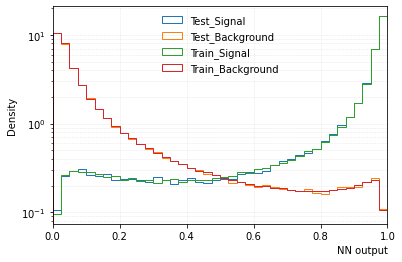

In [9]:
model=Load_Model("sstt_1", path_tosave)
Plot_NN_Output(model, train, test, True)

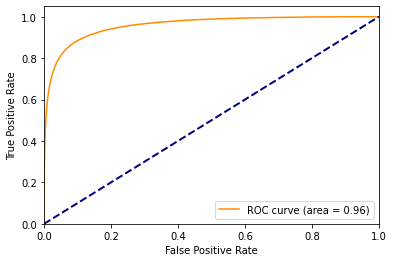

In [10]:
plot_roc_curve(model, test, path_tosave=path_tosave)

In [11]:
nn_scores_test = model.predict(test[0], verbose = True)
nn_scores = model.predict(train[0], verbose = True)

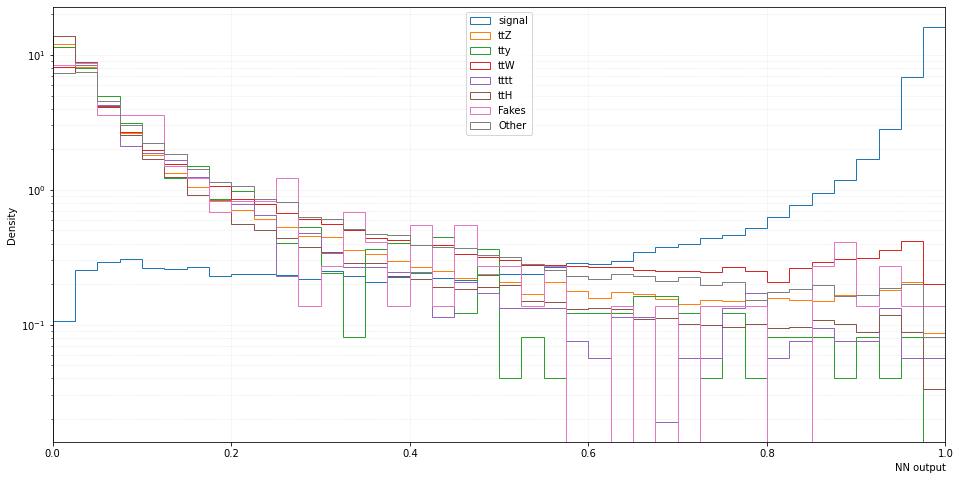

In [12]:
fig = plt.figure(figsize=(16,8))
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
for i in range(No_Classes):
    plt.hist(nn_scores_test[test[3]==i],label = class_names[i], **histargs)
plt.legend(loc='upper center')
    #plt.hist(nn_scores_test[test[1]==0][test[3]==i],label = "Test_Background", **histargs)

# Calc Signal cut for desired Singal Efficiency

In [13]:
Sig = nn_scores_test[test[1]==1]
Bkg = nn_scores_test[test[1]==0]
Sig_Eff, Bkg_Eff, Signal_Cut = Find_Eff_Cut(Sig=Sig, Bkg=Bkg, Signal_Eff=0.8)

Cut_Value: 0.981
Sig_Eff: 0.299
Bkg_Eff: 0.001
Bkg Rejection: 860.942


# Feature Importance

In [14]:
f = get_feature_importance(test, model, Signal_Cut, 2)
idx = np.argsort(f)

Text(0.5, 0, 'Feature Importance')

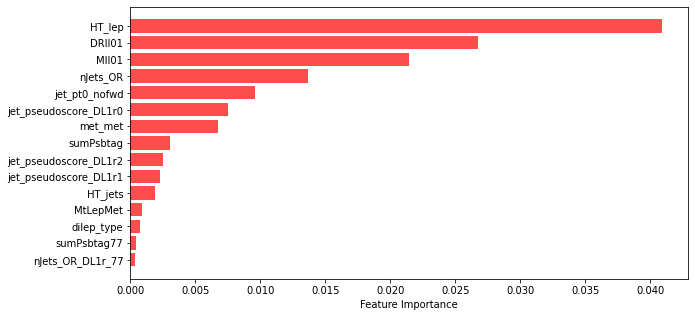

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(range(test[0].shape[1]), np.sort(f), color="r", alpha=0.7)
ax.set_yticks(range(train[0].shape[1]), np.array(feature_names)[idx])
ax.set_xlabel('Feature Importance')

# Confusion Matrix

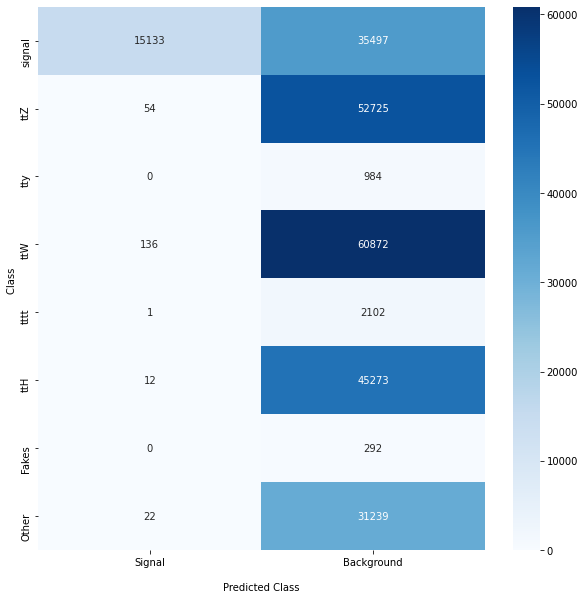

In [16]:
Make_Confusion_Matrix(test, nn_scores_test, Signal_Cut, class_names, False)

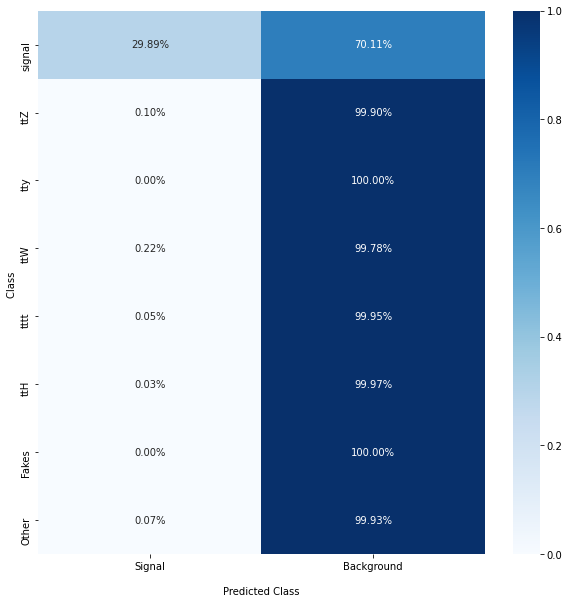

In [17]:
Make_Confusion_Matrix(test, nn_scores_test, Signal_Cut, class_names, True)